In [1]:
#------------------------------------------------------------------------------------------------
# HDBSCAN Clustering
# - 문장 임베딩 유사성을 기반으로 유사한 문장을 밀도(밀집도)로 클러스터링하는 HDBSCAN 알고리즘을 이용하는 클러스터링 예.
# - 테스트 data : newstrust_20210601_samlple.json 사용
#
# HDBSCAN(Hierarchical Density-Based Spatial Clustering of Applications with Noise) 설치
# - pip install hdbscan (conda install -c conda-forge hdbscan)
#
#------------------------------------------------------------------------------------------------
import torch
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')

import sys
sys.path.append('..')
from myutils import seed_everything, GPU_info, mlogging
logger = mlogging(loggername="HDBSCAN-cluster", logfilename="../../../log/cluster")
device = GPU_info()
seed_everything(111)

import hdbscan

logfilepath:../../../log/cluster_2023-05-17.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30


In [2]:
#-------------------------------------------------------------------------------------
# 1. 임베딩모델 로딩
# => bi_encoder 모델 로딩, polling_mode 설정
#-------------------------------------------------------------------------------------
import torch
from myutils import bi_encoder

bi_encoder_path = "bongsoo/kpf-sbert-128d-v1" #"bongsoo/kpf-sbert-v1.1" # kpf-sbert-v1.1 # klue-sbert-v1 # albert-small-kor-sbert-v1.1
pooling_mode = 'mean' # bert면=mean, albert면 = cls

 # 출력 임베딩 크기 지정 : 0=기본 모델 임베딩크기(768), 예:128=128 츨력임베딩 크기 
out_dimension = 128

word_embedding_model1, bi_encoder1 = bi_encoder(model_path=bi_encoder_path, max_seq_len=512, do_lower_case=True, 
                                              pooling_mode=pooling_mode, out_dimension=out_dimension, device=device)
  
print(f'\n---bi_encoder---------------------------')
print(bi_encoder1)
print(word_embedding_model1)
#------------------------------------------------------------------------------------------------------------------------


---bi_encoder---------------------------
SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 128, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)
Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 


In [3]:
#-------------------------------------------------------------------------------------
# 2. 문서로딩
# - [{"title":"다온플래닛, 인프라 모니터링 서비스 지원","category":"IT 과학"},
#    {"title":"텔레칩스, 러시아 자동차 OEM에 차량용 반도체 공급","category":"경제"},...]
#-------------------------------------------------------------------------------------
import re

DATA_PATH = 'data/newstrust_20210601_samlple.json'
df = pd.read_json(DATA_PATH, encoding='utf-8')
corpus = df['title'].values.tolist()

# 전처리
corpus_idx = []
for i, cp in enumerate(corpus):
    corpus[i] = re.sub(r'\[(.*?)\]','',cp)
    corpus_idx.append(i)
    
df['idx'] = corpus_idx
print(f'len(corpus): {len(corpus)}')

len(corpus): 12006


In [4]:
df.index

RangeIndex(start=0, stop=12006, step=1)

In [5]:
# 3.임베딩 벡터 구함
corpus_embeddings = bi_encoder1.encode(corpus, show_progress_bar=True)
print(f'len(corpus_embeddings): {len(corpus_embeddings)}')

Batches:   0%|          | 0/376 [00:00<?, ?it/s]

len(corpus_embeddings): 12006


In [29]:
# 4. 클러스터링 모델 생성
# -> min_samples: 최소샘플링계수(기본=None), min_cluster_size : 최소 클러스터링 계수
cluster_model = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=15)

In [30]:
# 5. 클러스터링 모델 훈련
# => -1은 클러스터링 안된 데이터임.
cluster_model.fit(corpus_embeddings)

labels = cluster_model.labels_
print(f'labels:{labels[0:100]}')

labels:[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 61
 -1 -1  3 -1 -1 -1 -1 -1 -1 40 -1 -1 -1 61 -1 -1 -1 -1 -1 -1 62 -1 -1 -1
 -1 -1 -1 -1 -1 -1 61 -1 29 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 62 -1
 60 -1  1 -1 -1 59 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 62 -1 62 -1 -1 -1 -1
 -1 -1 -1 -1]


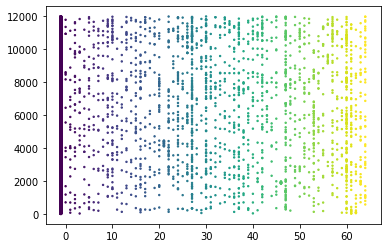

In [31]:
# 6. 클러스터링 결과를 df에 추가 후 시각화
import matplotlib.pyplot as plt

df['cluster'] = labels

# 클러스터 레이블을 matplotlib을 사용하여 시각화합니다.
# scatter 인자 => x축, y축, c=color(점컬러), s=size(점size)
plt.scatter(df['cluster'], df.index, c=df['cluster'], s=2)
plt.show()